* Project: To create simple RNN to predict next data point with given data points
* Data source: Creating data for this RNN
* Author: Shashi Kiran Chilukuri

## Importing Libraries/Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn

## Creating and Visualizing data

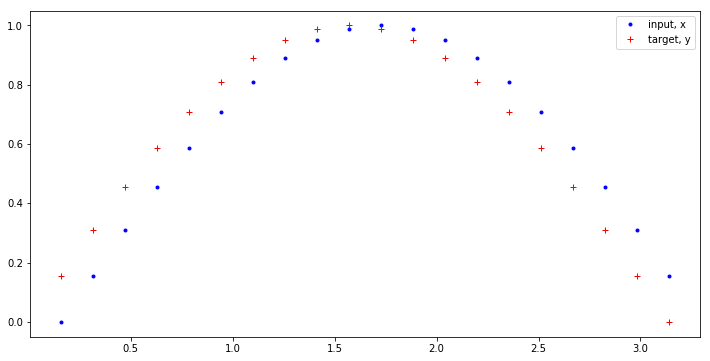

In [26]:
# Creating 20 evenly spaced data points
data_points = np.linspace(0, np.pi, 21)
data = np.sin(data_points)

# Converting into vector
data.resize(21,1)
# inputs and targets
inputs = data[:-1]
targets = data[1:]

# Visualizing the data
plt.figure(figsize=(12,6))
plt.plot(data_points[1:], inputs, 'b.', label='input, x') # x
plt.plot(data_points[1:], targets, 'r+', label='target, y') # y

plt.legend(loc='best')
plt.show()

## Defining the RNN

CLASS torch.nn.RNN()

Applies a multi-layer Elman RNN with tanhtanh or ReLUReLU non-linearity to an input sequence.

Parameters:	
- input_size – The number of expected features in the input x
- hidden_size – The number of features in the hidden state h
- num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two RNNs together to form a stacked RNN, with the second RNN taking in outputs of the first RNN and computing the final results. Default: 1
- nonlinearity – The non-linearity to use. Can be either ‘tanh’ or ‘relu’. Default: ‘tanh’
- bias – If False, then the layer does not use bias weights b_ih and b_hh. Default: True
- batch_first – If True, then the input and output tensors are provided as (batch, seq, feature). Default: False
- dropout – If non-zero, introduces a Dropout layer on the outputs of each RNN layer except the last layer, with dropout probability equal to dropout. Default: 0
- bidirectional – If True, becomes a bidirectional RNN. Default: False

- Dimensions:
    - ** input(x) (batch_size, seq_length, input_size) **
    - ** hidden(h) (n_layers, batch_size, hidden_size) **
    - ** output(r_out) (batch_size x seq_length, hidden_size) **
                        (batch_size, data_step, hidden_size)

In [28]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_size=hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, n_layers, batch_first=True) # defining RNN
        # batch_first: If True, then the input and output tensors are provided as (batch, seq, feature)
        # i.e, first dim of the input and output will be the batch_size
        # n_layers usually, is kept between 1 and 3 layers
        self.fc = nn.Linear(hidden_size, output_size) # last, fully-connected layer

    def forward(self, x, hidden):
        batch_size = x.size(0)
        r_out, hidden = self.rnn(x, hidden) # get RNN outputs
        r_out = r_out.view(-1, self.hidden_size) # Output shape (batch_size*seq_length, hidden_dim)
        output = self.fc(r_out) # get final output 
        
        return output, hidden

### Checking out dimensions

In [29]:
# test that dimensions are as expected
test_rnn = RNN(input_size=1, output_size=1, hidden_size=10, n_layers=2)
seq_length = 20
# generate evenly spaced, test data pts
data_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(data_steps)
data.resize((seq_length, 1))

test_input = torch.Tensor(data).unsqueeze(0) # give it a batch_size of 1 as first dimension
print('Input size: ', test_input.size())

# test out rnn sizes
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

Input size:  torch.Size([1, 20, 1])
Output size:  torch.Size([20, 1])
Hidden state size:  torch.Size([2, 1, 10])


### Defining RNN, Criterion, Optimizer

In [30]:
# decide on hyperparameters
input_size=1 
output_size=1
hidden_size=32
n_layers=1

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_size, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [31]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01) 

### Training

In [34]:
def train(rnn, n_steps, print_every):
    hidden = None      # initialize the hidden state
    
    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data 
        data_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
        data = np.sin(data_steps)
        data.resize((seq_length + 1, 1)) # input_size=1

        x = data[:-1]
        y = data[1:]
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        loss = criterion(prediction, y_tensor) # calculate the loss
        optimizer.zero_grad()                  # zero gradients
        loss.backward()                        # perform backprop and update weights
        optimizer.step()

        # display loss and predictions
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            plt.plot(data_steps[1:], x, 'r.') # input
            plt.plot(data_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
            plt.show()
    
    return rnn

Loss:  0.30913519859313965


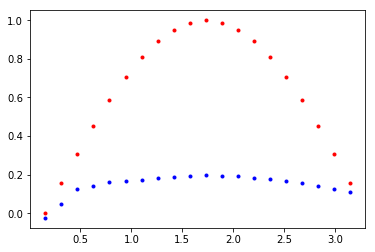

Loss:  0.0012136137811467052


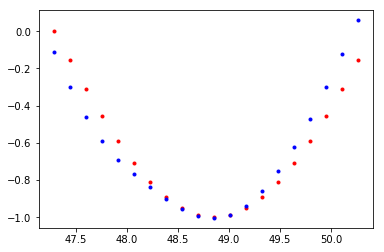

Loss:  0.0006995552103035152


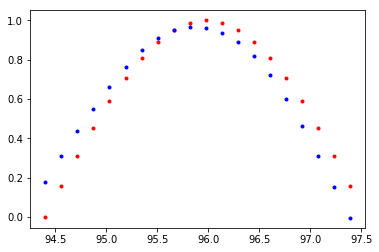

Loss:  0.0005178389837965369


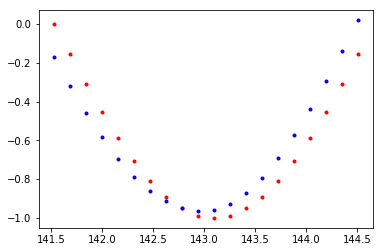

Loss:  0.00045122619485482574


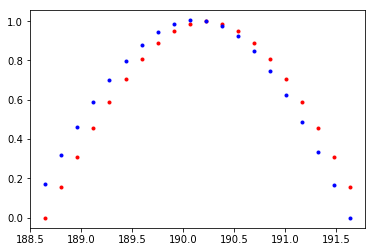

In [35]:
# train the rnn and monitor results
n_steps = 75
print_every = 15

trained_rnn = train(rnn, n_steps, print_every)